In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
import warnings
# from sklearn.feature_selection import RFE
# from sklearn.linear_model import LassoCV

warnings.filterwarnings('ignore')

# URL of the dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv'

# Load the dataset
df = pd.read_csv(url)

In [26]:
# Preprocessing
df['month'] = pd.Categorical(df['month']).codes
df['day'] = pd.Categorical(df['day']).codes
df.drop(['X', 'Y'], axis=1, inplace=True)

# Separate features and target
X = df.drop(['area'], axis=1)
y = df['area']

In [27]:
# Feature selection
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [28]:
# Select top 5 features
selector = SelectKBest(score_func=f_regression, k=5)
selector.fit(X_scaled, y)

feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': selector.scores_
})
selected_features = feature_scores.nlargest(5, 'Score')['Feature'].tolist()
X_selected = X_scaled[selected_features]

In [29]:
# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=1.0),
    'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    # 'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    # 'SVR': SVR(kernel='rbf'),
}

In [30]:
# Evaluate models
results = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    cv_rmse = -cross_val_score(model, X_selected, y, 
                              scoring='neg_root_mean_squared_error', 
                              cv=kf)
    cv_r2 = cross_val_score(model, X_selected, y, 
                           scoring='r2', 
                           cv=kf)
    
    results.append({
        'Model': name,
        'RMSE_Mean': cv_rmse.mean(),
        'RMSE_Std': cv_rmse.std(),
        'R2_Mean': cv_r2.mean(),
        'R2_Std': cv_r2.std()
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('RMSE_Mean')

Text(0, 0.5, 'F-Score')

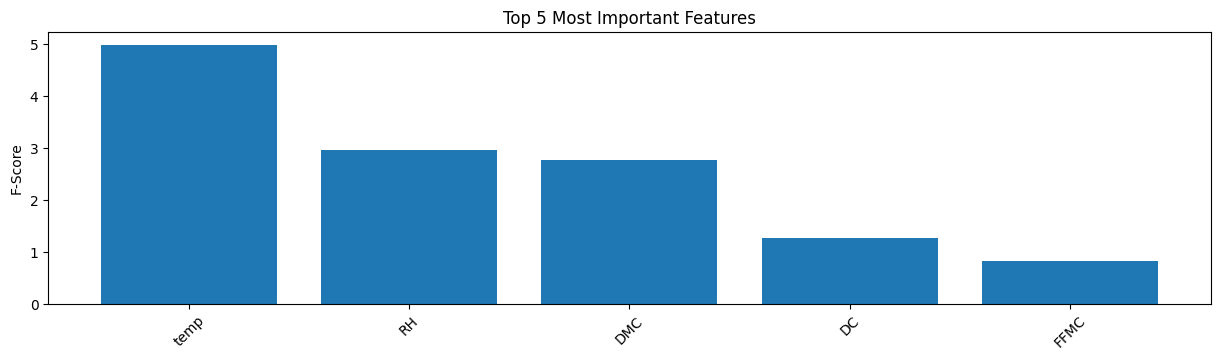

In [31]:
# Plotting
plt.figure(figsize=(15, 12))

# Plot 1: Feature Importance
plt.subplot(3, 1, 1)
feature_plot_data = feature_scores.nlargest(5, 'Score')
plt.bar(feature_plot_data['Feature'], feature_plot_data['Score'])
plt.title('Top 5 Most Important Features')
plt.xticks(rotation=45)
plt.ylabel('F-Score')

Text(0, 0.5, 'RMSE')

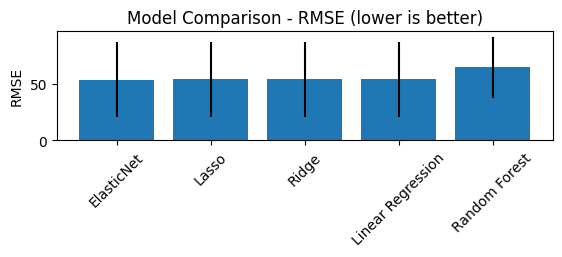

In [32]:
# Plot 2: Model RMSE Comparison
plt.subplot(3, 1, 2)
plt.bar(results_df['Model'], results_df['RMSE_Mean'])
plt.errorbar(results_df['Model'], results_df['RMSE_Mean'], 
             yerr=results_df['RMSE_Std'], fmt='none', color='black')
plt.title('Model Comparison - RMSE (lower is better)')
plt.xticks(rotation=45)
plt.ylabel('RMSE')

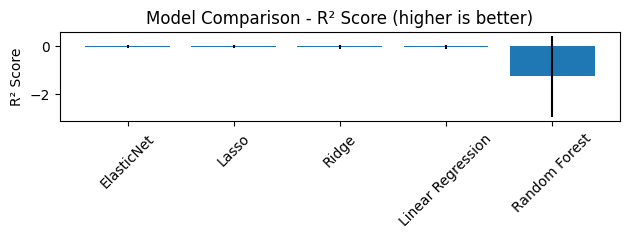

In [33]:
# Plot 3: Model R² Comparison
plt.subplot(3, 1, 3)
plt.bar(results_df['Model'], results_df['R2_Mean'])
plt.errorbar(results_df['Model'], results_df['R2_Mean'], 
             yerr=results_df['R2_Std'], fmt='none', color='black')
plt.title('Model Comparison - R² Score (higher is better)')
plt.xticks(rotation=45)
plt.ylabel('R² Score')

plt.tight_layout()
plt.show()

In [34]:
# Print detailed results
print("\nSelected Features (in order of importance):")
for feature, score in feature_scores.nlargest(5, 'Score').itertuples(index=False):
    print(f"{feature}: {score:.4f}")

print("\nModel Performance Summary:")
print(results_df.round(4))


Selected Features (in order of importance):
temp: 4.9780
RH: 2.9539
DMC: 2.7587
DC: 1.2590
FFMC: 0.8304

Model Performance Summary:
               Model  RMSE_Mean  RMSE_Std  R2_Mean  R2_Std
3         ElasticNet    53.8842   33.4383  -0.0336  0.0539
2              Lasso    53.9915   33.3733  -0.0416  0.0591
1              Ridge    54.0701   33.2627  -0.0501  0.0682
0  Linear Regression    54.0722   33.2617  -0.0502  0.0683
4      Random Forest    64.8358   27.3033  -1.2619  1.6819


In [35]:
# Find best model
best_model = results_df.iloc[0]['Model']
best_rmse = results_df.iloc[0]['RMSE_Mean']
best_r2 = results_df.iloc[0]['R2_Mean']

print(f"\nBest Performing Model: {best_model}")
print(f"RMSE: {best_rmse:.4f} (±{results_df.iloc[0]['RMSE_Std']:.4f})")
print(f"R²: {best_r2:.4f} (±{results_df.iloc[0]['R2_Std']:.4f})")

# Compare with baseline
baseline_rmse = results_df[results_df['Model'] == 'Linear Regression']['RMSE_Mean'].values[0]
improvement = ((baseline_rmse - best_rmse) / baseline_rmse) * 100
print(f"\nImprovement over Linear Regression: {improvement:.2f}%")


Best Performing Model: ElasticNet
RMSE: 53.8842 (±33.4383)
R²: -0.0336 (±0.0539)

Improvement over Linear Regression: 0.35%


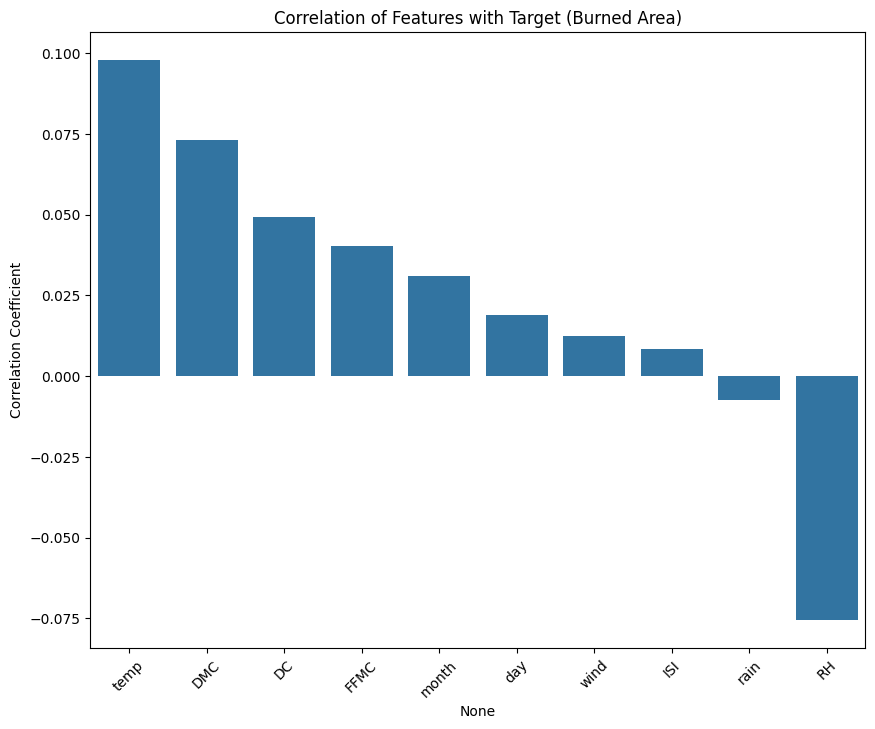

In [36]:
# # Separate features and target
# X = df.drop(columns=["area", "month", "day"])  # Exclude target and categorical features for now
# y = df["area"]

# 1. Correlation Analysis
plt.figure(figsize=(10, 8))
correlation_matrix = X.corrwith(y).sort_values(ascending=False)
sns.barplot(x=correlation_matrix.index, y=correlation_matrix.values)
plt.xticks(rotation=45)
plt.title("Correlation of Features with Target (Burned Area)")
plt.ylabel("Correlation Coefficient")
plt.show()